In [1]:
#whole lotta inputs ASTRO RELated
from astroquery.vizier import Vizier

import matplotlib.pyplot as plt
import csv
from astropy.table import Table
import pandas as pd


import numpy as np

#machine learning inputs
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [5]:
pwd

'/Users/alexabeyer/Desktop/machinelearning/github'

In [9]:
galah = Table.read('/Users/alexabeyer/Desktop/research/data/GALAH_DR3_main_allstar_v2.fits')


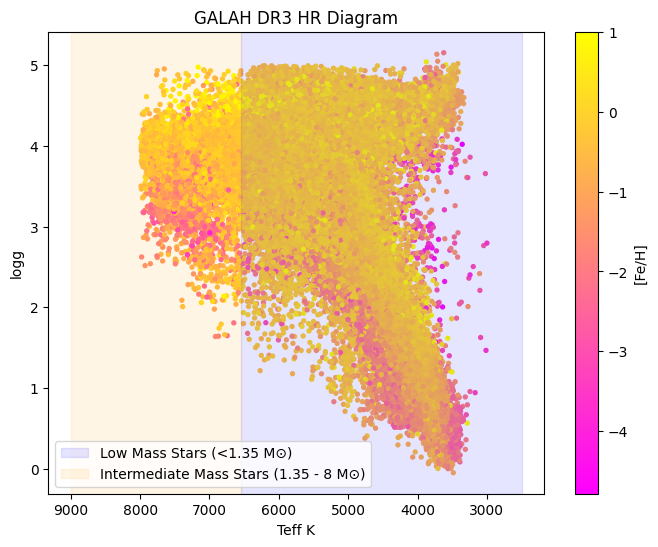

In [11]:
plt.figure(figsize=(8, 6))

sc = plt.scatter(galah['teff'], galah['logg'], c=galah['fe_h'], cmap='spring', s=8)
plt.colorbar(sc, label='[Fe/H]')
plt.gca().invert_xaxis()
plt.xlabel('Teff K')
plt.ylabel("logg")
# plt.ylim(-100,50e4)
plt.title("GALAH DR3 HR Diagram")

#Hr diagram markers 
teff = galah['teff']

# Plot shaded regions for mass groups
plt.axvspan(2500, 6550, color='blue', alpha=0.1, label='Low Mass Stars (<1.35 M⊙)')
plt.axvspan(6550, 9000, color='orange', alpha=0.1, label='Intermediate Mass Stars (1.35 - 8 M⊙)')

# Show the plot
plt.legend()
plt.savefig('galah_hrdiagram.png')
plt.show()

In [13]:
spectral_types_break = ['F0', 'Kraft Break', 'G0', 'K0', 'M0']
teff_values = [7220, 6550, 5930, 5270, 3850]

def clustering(nclust, X, true_labels, centers_arg=True):
    kmeans = KMeans(n_clusters=nclust, random_state=0, n_init="auto").fit(X)
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_

    # Sort cluster labels by Teff (column 0)
    sorted_indices = np.argsort(centers[:, 0])
    label_mapping = {old: new for new, old in enumerate(sorted_indices)}
    labels = np.vectorize(label_mapping.get)(labels)

    x_plot = df['teff'].iloc[::5]
    y_plot = X['logg'].iloc[::5]

    fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
    points = axs[0].scatter(x_plot, y_plot, c=labels[::5], s=4)
    misclassified = labels[::5] - true_labels[::5]
    points_misclass = axs[1].scatter(x_plot, y_plot, c=misclassified, s=4, cmap='Set1')

    for ax in axs:
        y_top = ax.get_ylim()[1]
        for teff, label in zip(teff_values, spectral_types_break):
            ax.axvline(teff, color='black', linestyle='--', linewidth=0.8)
            y_offset = 0.3 if label != 'Kraft Break' else 1.2
            ax.text(teff, y_top - y_offset, label,
                    rotation=90 if label == 'Kraft Break' else 0,
                    verticalalignment='top',
                    horizontalalignment='center',
                    fontsize=9)
            
        if centers_arg:
            ax.scatter(centers[:, 0], centers[:, 1], marker='x', c='black', s=80, label='Centers')
        ax.set_title("GALAH Cluster HR Diagram")
        ax.set_xlabel('Temperature (K)')
        ax.set_ylabel(r'logg (cm^2s_1)')
        ax.invert_xaxis()
        ax.legend()

    fig.colorbar(points, ax=axs[0], label='Cluster label')
    fig.colorbar(points_misclass, ax=axs[1], label='Label Difference')

    plt.tight_layout()
    plt.savefig(f'gaia_tess_cluster{nclust}_HR.png')  # <-- dynamically include nclust
    plt.show()

    return labels, centers

In [15]:
GALAH = galah["teff", #Effective temperature of the star (a derived quantity)
    #"e_Teff", #Error in effective temperature
    "logg", #Log surface gravity
    #"e_logg", #error in surface gravity
    "fe_h", #Metallicity (ratio of iron to hydrogen)
    #"e_FeH", #error in metallicit
    "vbroad" #rotational velocity 
]

df = GALAH.to_pandas()
df = df.dropna()
df

fitcolsT = [
    "teff", #Effective temperature of the star (a derived quantity)
    #"e_Teff", #Error in effective temperature
    "logg", #Log surface gravity
    #"e_logg", #error in surface gravity
    "fe_h", #Metallicity (ratio of iron to hydrogen)
    #"e_FeH", #error in metallicit
    "vbroad" #rotational velocity 
    
]

XT = df[fitcolsT]
y= df['teff']

bin_edges = [float('inf'),  # for F0 and hotter
             (7220 + 6550)/2,
             (6550 + 5930)/2,
             (5930 + 5270)/2,
             (5270 + 3850)/2,
             float('-inf')]  # for M0 and cooler

bin_edges = bin_edges[::-1]  # smallest to largest

spectral_labels = np.arange(6)

conditions = [
    (df['teff'] > bin_edges[i]) & (df['teff'] <= bin_edges[i+1])
    for i in range(len(bin_edges) - 1)
]

spectral_labels = [0, 1, 2, 3, 4]

labels_5clust = np.select(conditions, spectral_labels)

/var/folders/1r/_ykm9y417ll0tmt7btm3lkd00000gn/T/ipykernel_77144/1230350401.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


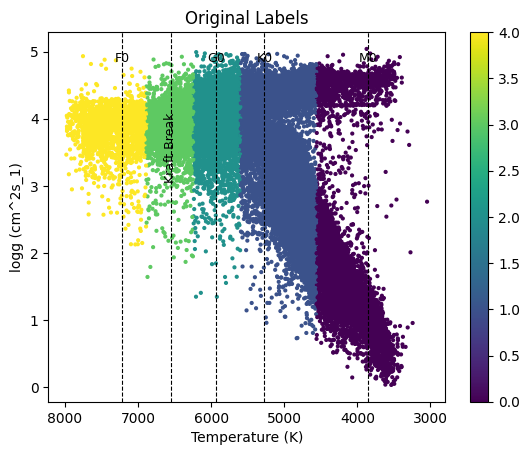

In [17]:
#original data
fig, ax = plt.subplots()
points = ax.scatter(df['teff'].iloc[::5], df['logg'].iloc[::5], c=labels_5clust[::5], s=4)
ax.set_title("Original Labels")
ax.set_xlabel('Temperature (K)')
ax.set_ylabel(r'logg (cm^2s_1)')
ax.invert_xaxis()
spectral_types_break = ['F0', 'Kraft Break', 'G0', 'K0', 'M0']
teff_values = [7220, 6550, 5930, 5270, 3850]
y_top = ax.get_ylim()[1]
for teff, label in zip(teff_values, spectral_types_break):
    ax.axvline(teff, color='black', linestyle='--', linewidth=0.8)
    y_offset = 0.3 if label != 'Kraft Break' else 1.2
    ax.text(teff, y_top - y_offset, label,
            rotation=90 if label == 'Kraft Break' else 0,
            verticalalignment='top',
            horizontalalignment='center',
            fontsize=9)
fig.colorbar(points, ax=ax)
fig.show()


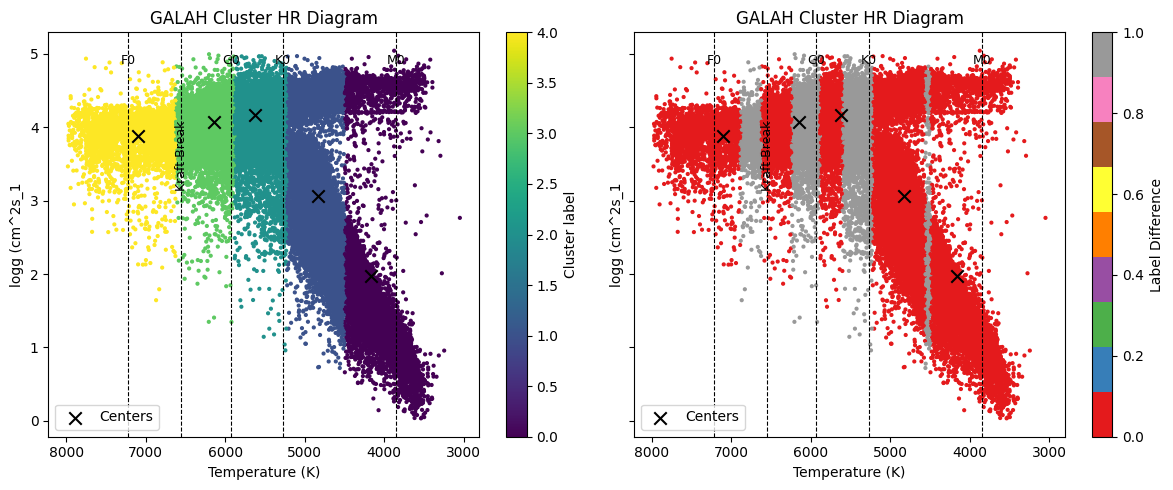

In [21]:
#running cluster on five groups 
labels5, clusters5 = clustering(5, XT, labels_5clust)

In [23]:
#settings with temeprature included
boundsT = [[min(XT['teff'].to_numpy()[np.where(labels5==spec_class)]), max(XT['teff'].to_numpy()[np.where(labels5==spec_class)])] for spec_class in spectral_labels]

ConfusionMatrix [[ 56657  12239      0      0      0]
 [     0 161959  69240      0      0]
 [     0      0 100742 103541      0]
 [     0      0      0  42389   7423]
 [     0      0      0      0  13218]]
              precision    recall  f1-score   support

           0       1.00      0.82      0.90     68896
           1       0.93      0.70      0.80    231199
           2       0.59      0.49      0.54    204283
           3       0.29      0.85      0.43     49812
           4       0.64      1.00      0.78     13218

    accuracy                           0.66    567408
   macro avg       0.69      0.77      0.69    567408
weighted avg       0.75      0.66      0.69    567408



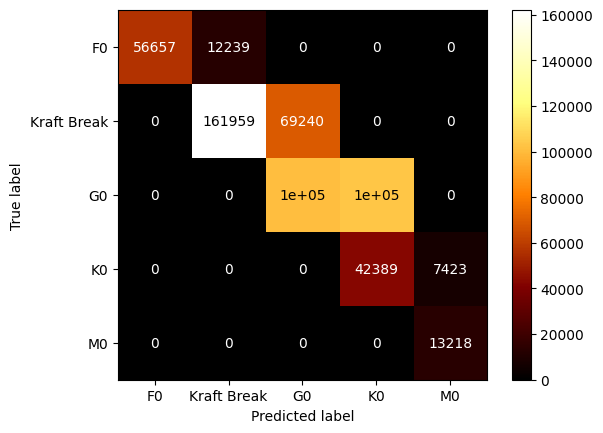

In [25]:
#WITH TEFF
spectral_types_break = ['F0', 'Kraft Break', 'G0', 'K0', 'M0']
#teff_values = [7220, 6550, 5930, 5270, 3850]
cm = confusion_matrix(labels_5clust,labels5)
print("ConfusionMatrix",cm)
print(classification_report(labels_5clust,labels5))

disp = ConfusionMatrixDisplay(cm, display_labels = spectral_types_break)
disp.plot(cmap='afmhot')
plt.show()

In [27]:
# spectral_types_break = ['Low Mass', 'Intermediate Mass', 'High Mass']
# #teff_values = [7220, 6550, 5930, 5270, 3850]
# cm = confusion_matrix(labels_3clust,labels3)
# print("ConfusionMatrix",cm)
# print(classification_report(labels_3clust, labels3))
# disp = ConfusionMatrixDisplay(cm, display_labels = spectral_types_break)
# disp.plot(cmap='afmhot')
# plt.show()

In [88]:
#columnns with no temperature variable
fitcolsnT = [
    "logg", #Log surface gravity
    # "teff", #effective temeprature of star
    "vbroad", #angular radius of star
    'fe_h' #Metallicity (ratio of iron to hydrogen)
]
XnT = df[fitcolsnT]

/var/folders/1r/_ykm9y417ll0tmt7btm3lkd00000gn/T/ipykernel_77144/2513372364.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


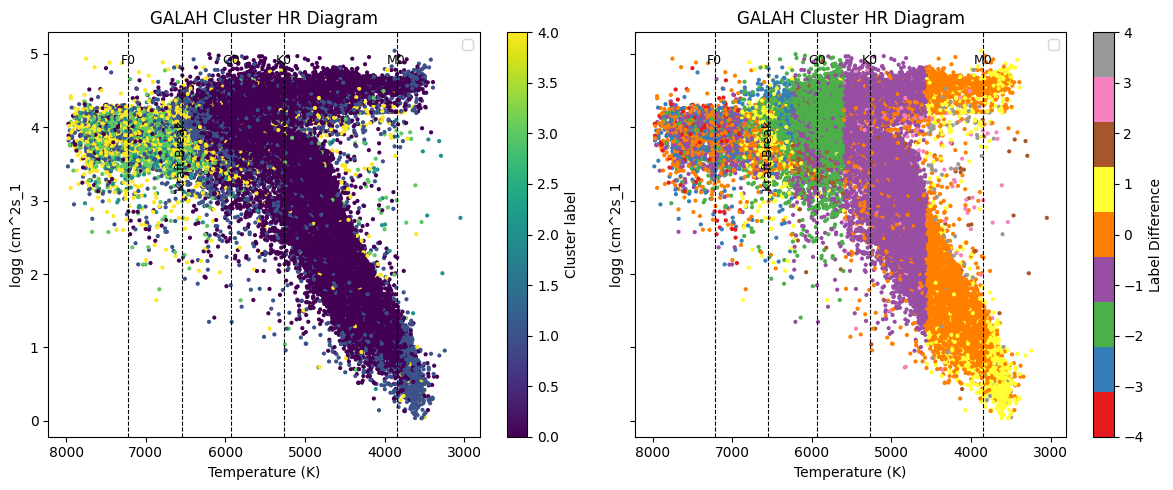

In [90]:
#cluster with no temperature"
labels5nT, clusters5nT = clustering(5, XnT, labels_5clust, centers_arg=False)

In [91]:
#showing the bounds without temperature
boundsnT = [[min(df['teff'].to_numpy()[np.where(labels5nT==spec_class)]), max(df['teff'].to_numpy()[np.where(labels5nT==spec_class)])] for spec_class in spectral_labels]
print(boundsnT)
print(boundsT)

[[np.float32(3169.4187), np.float32(7980.5884)], [np.float32(3243.9434), np.float32(7993.1465)], [np.float32(3022.1433), np.float32(7954.0283)], [np.float32(3013.572), np.float32(7977.8877)], [np.float32(3000.0), np.float32(7981.7065)]]
[[np.float32(3000.0), np.float32(4495.124)], [np.float32(4495.1255), np.float32(5224.956)], [np.float32(5224.9766), np.float32(5883.527)], [np.float32(5883.4937), np.float32(6623.7485)], [np.float32(6621.095), np.float32(7993.1465)]]


ConfusionMatrix [[ 59107   8653    131    235    770]
 [216339  12888     95    291   1586]
 [177441  22702    194    531   3415]
 [ 13724  20668   1050   4178  10192]
 [   854   2600   1559   3816   4389]]
              precision    recall  f1-score   support

           0       0.13      0.86      0.22     68896
           1       0.19      0.06      0.09    231199
           2       0.06      0.00      0.00    204283
           3       0.46      0.08      0.14     49812
           4       0.22      0.33      0.26     13218

    accuracy                           0.14    567408
   macro avg       0.21      0.27      0.14    567408
weighted avg       0.16      0.14      0.08    567408



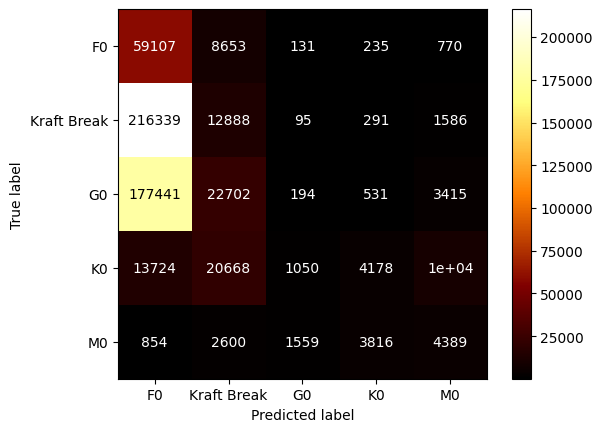

In [92]:
#WITHOUT TEFF 
cm = confusion_matrix(labels_5clust,labels5nT)
print("ConfusionMatrix",cm)
print(classification_report(labels_5clust,labels5nT))
disp = ConfusionMatrixDisplay(cm, display_labels = spectral_types_break)
disp.plot(cmap='afmhot')
plt.show()

# PCA

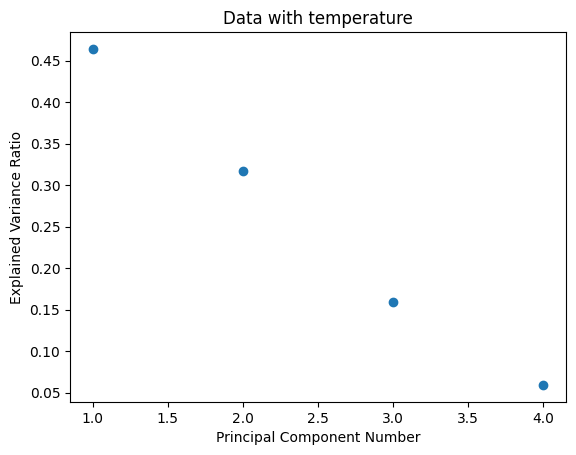

In [94]:
from sklearn.decomposition import PCA
df_norm = (XT - XT.mean()) / XT.std()
ncomp=len(fitcolsT)
pcaT = PCA(n_components=ncomp)
x_transform = pcaT.fit_transform(df_norm)
explained_variances = pcaT.explained_variance_ratio_
plt.scatter(np.arange(1,ncomp+1), explained_variances)
plt.xlabel('Principal Component Number')
plt.ylabel('Explained Variance Ratio')
plt.title('Data with temperature')
plt.show()

In [95]:
loadingsT = pd.DataFrame(pcaT.components_.T,
                        columns=[f'PC{i+1}' for i in range(len(fitcolsT))],
                        index=XT.columns)
loadingsT

,PC1,PC2,PC3,PC4
teff,0.655350,0.215891,-0.221215,0.689182
logg,0.643216,-0.214419,-0.337717,-0.652874
fe_h,0.291974,-0.650071,0.686130,0.146233
vbroad,0.267470,0.696293,0.605175,-0.278208


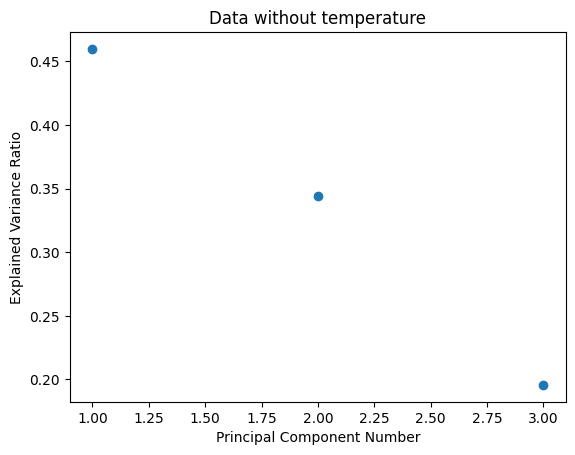

In [96]:
#performing a PCA on the cluster data 
from sklearn.decomposition import PCA
df_norm = (XnT - XnT.mean()) / XnT.std()
ncomp=len(fitcolsnT)
pcanT = PCA(n_components=ncomp)
x_transform = pcanT.fit_transform(df_norm)
explained_variances = pcanT.explained_variance_ratio_
plt.scatter(np.arange(1,ncomp+1), explained_variances)
plt.xlabel('Principal Component Number')
plt.ylabel('Explained Variance Ratio')
plt.title('Data without temperature')
plt.show()

In [97]:
#inputing the loadings without temp
loadingsnT = pd.DataFrame(pcanT.components_.T,
                        columns=[f'PC{i+1}' for i in range(len(fitcolsnT))],
                        index=XnT.columns)
loadingsnT

,PC1,PC2,PC3
logg,0.644323,0.433642,-0.629922
vbroad,-0.257495,0.898615,0.355229
fe_h,0.720100,-0.066680,0.690659


# Supervised Classification

In [99]:
#creating the classification boundsto apply 
spectral_types_clf_labels = ['F0', 'Kraft Break', 'G0', 'K0', 'M0']
teff_values = [7220, 6550, 5930, 5270, 3850]

reg_df = df.copy()
reg_df['label'] = labels_5clust

In [100]:
#Random forest classification because it is supervised, so train some of the data on classification system and then test on 20%

#Split data into train and test set
X = reg_df[fitcolsT]
y = reg_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
clf = RandomForestClassifier(n_estimators = 100, random_state = 42, criterion='log_loss')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

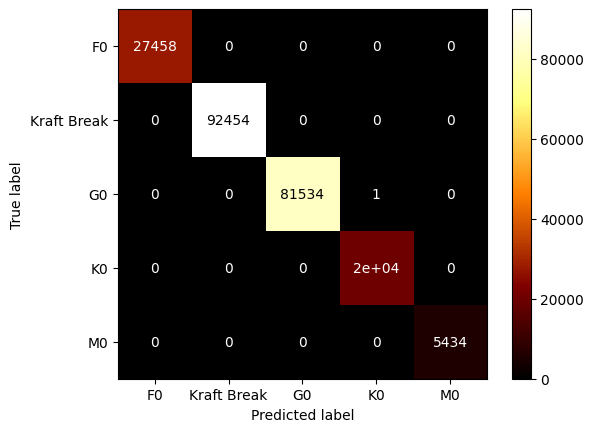

In [101]:
#creating a confusion matrix 
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels = spectral_types_clf_labels)
disp.plot(cmap='afmhot')
plt.show()

/var/folders/1r/_ykm9y417ll0tmt7btm3lkd00000gn/T/ipykernel_77144/3307216675.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


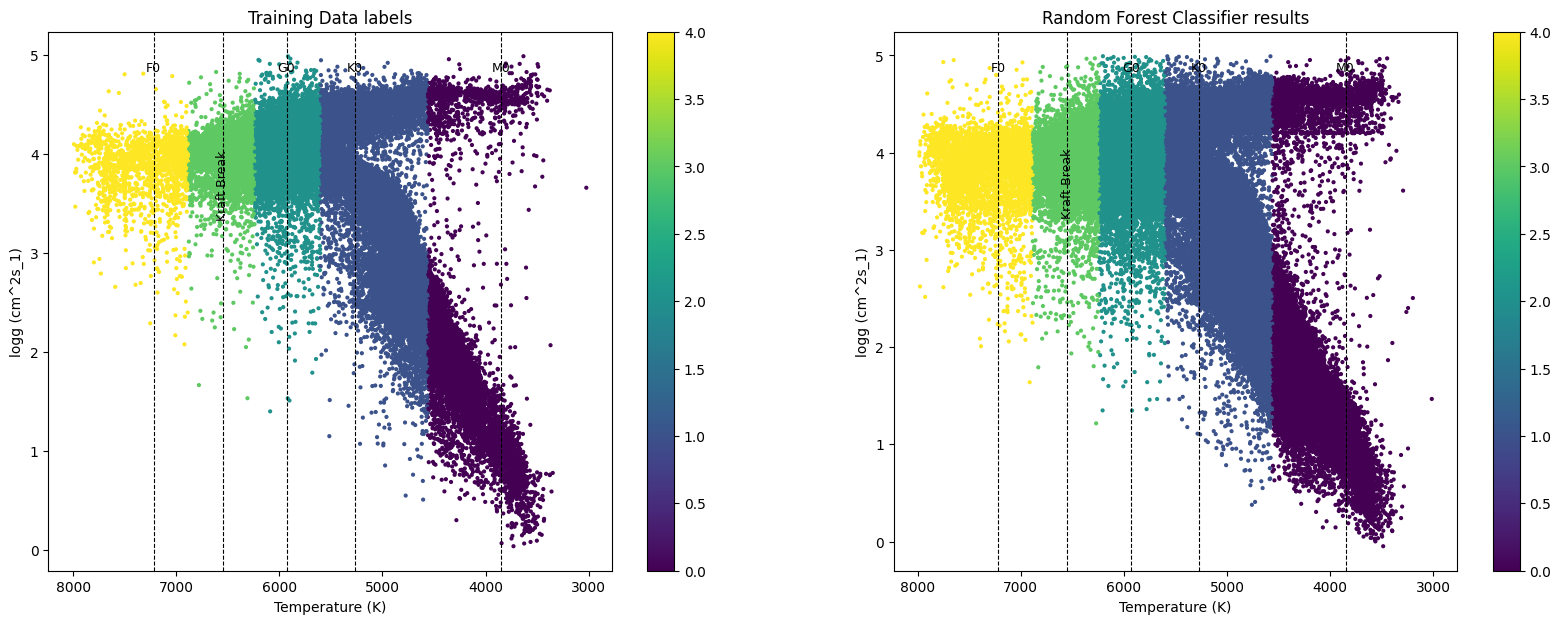

In [102]:
#plotting the training labels and the random forest results 
fig, ax = plt.subplots(1,2, figsize=(20,7))
points = ax[1].scatter(X_test['teff'], X_test['logg'], c=y_pred, s=4)
ax[0].scatter(X_train['teff'].iloc[::5], X_train['logg'].iloc[::5], c=y_train[::5], s=4)
ax[1].set_title("Random Forest Classifier results")
ax[0].set_title("Training Data labels")

for a in ax:
    a.set_xlabel('Temperature (K)')
    a.set_ylabel(r'logg (cm^2s_1)')
    a.invert_xaxis()
    y_top = a.get_ylim()[1]
    for teff, label in zip(teff_values, spectral_types_break):
        a.axvline(teff, color='black', linestyle='--', linewidth=0.8)
        y_offset = 0.3 if label != 'Kraft Break' else 1.2
        a.text(teff, y_top - y_offset, label,
                rotation=90 if label == 'Kraft Break' else 0,
                verticalalignment='top',
                horizontalalignment='center',
                fontsize=9)
    fig.colorbar(points, ax=a)

fig.show()

In [103]:
#printing the resulting bounds from the random forest 
boundsRFC = [[min(df['teff'].to_numpy()[np.where(y_pred==spec_class)]), max(df['teff'].to_numpy()[np.where(y_pred==spec_class)])] for spec_class in spectral_labels]
boundsRFC

[[np.float32(3347.6985), np.float32(7925.7275)],
 [np.float32(3013.572), np.float32(7981.7065)],
 [np.float32(3022.1433), np.float32(7978.5923)],
 [np.float32(3242.2017), np.float32(7984.065)],
 [np.float32(3281.4165), np.float32(7881.9126)]]

In [105]:
#printing the bounds of the included temp results 
boundsT = [[min(XT['teff'].to_numpy()[np.where(labels5==spec_class)]), max(XT['teff'].to_numpy()[np.where(labels5==spec_class)])] for spec_class in [0, 1, 2, 3, 4]]
boundsT

[[np.float32(3000.0), np.float32(4495.124)],
 [np.float32(4495.1255), np.float32(5224.956)],
 [np.float32(5224.9766), np.float32(5883.527)],
 [np.float32(5883.4937), np.float32(6623.7485)],
 [np.float32(6621.095), np.float32(7993.1465)]]

              precision    recall  f1-score   support

           0       1.00      0.82      0.90     68896
           1       0.93      0.70      0.80    231199
           2       0.59      0.49      0.54    204283
           3       0.29      0.85      0.43     49812
           4       0.64      1.00      0.78     13218

    accuracy                           0.66    567408
   macro avg       0.69      0.77      0.69    567408
weighted avg       0.75      0.66      0.69    567408



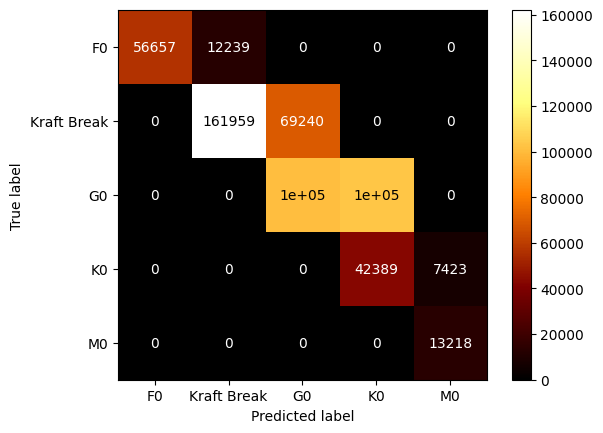

In [108]:
#showing the confusion matrix of the 5 group cluster without temp
spectral_types_break = ['F0', 'Kraft Break', 'G0', 'K0', 'M0']
#teff_values = [7220, 6650, 5930, 5270, 3850]
cm = confusion_matrix(labels_5clust,labels5)
print(classification_report(labels_5clust,labels5))

disp = ConfusionMatrixDisplay(cm, display_labels = spectral_types_break)
disp.plot(cmap='afmhot')
plt.show()

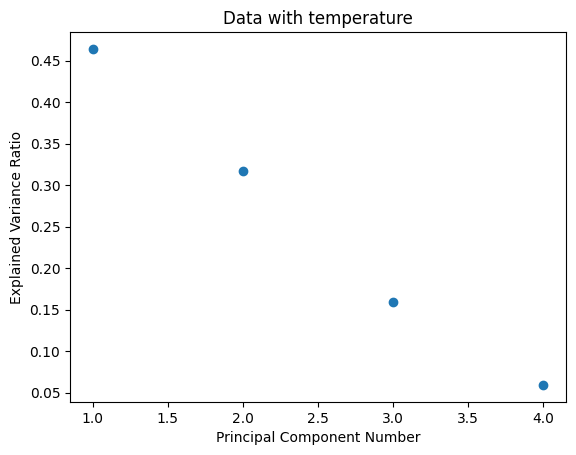

In [114]:
#plotting the PCA of the included temeprature data set
fitcols = ["teff", #Effective temperature of the star (a derived quantity)
    #"e_Teff", #Error in effective temperature
    "logg", #Log surface gravity
    #"e_logg", #error in surface gravity
    "fe_h", #Metallicity (ratio of iron to hydrogen)
    #"e_FeH", #error in metallicit
    "vbroad" #rotational velocity 
]
df_norm = (XT - XT.mean()) / XT.std()
ncomp=len(fitcols)
pcaT = PCA(n_components=ncomp)
x_transform = pcaT.fit_transform(df_norm)
explained_variances = pcaT.explained_variance_ratio_
plt.scatter(np.arange(1,ncomp+1), explained_variances)
plt.xlabel('Principal Component Number')
plt.ylabel('Explained Variance Ratio')
plt.title('Data with temperature')
plt.show()

In [115]:
#printing the resulting loadings of the pca with temp
loadings = pd.DataFrame(pcaT.components_.T,
                        columns=[f'PC{i+1}' for i in range(len(fitcols))],
                        index=XT.columns)
loadings

,PC1,PC2,PC3,PC4
teff,0.655350,0.215891,-0.221215,0.689182
logg,0.643216,-0.214419,-0.337717,-0.652874
fe_h,0.291974,-0.650071,0.686130,0.146233
vbroad,0.267470,0.696293,0.605175,-0.278208


# Supervised Learning

In [117]:
#creating another data frame of the cluster labels with 5 groupings.
reg_df = df.copy()
reg_df['label'] = labels_5clust

In [ ]:
#training the data set on the temp included 5 cluster 
X = reg_df[fitcols]
y = reg_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
clf = RandomForestClassifier(n_estimators = 100, random_state = 42, criterion='log_loss')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

In [ ]:
#plotting the 5 cluster temp matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels = spectral_types_break)
disp.plot(cmap='afmhot')
plt.show()

In [ ]:
#plotting the resulting trained groups 
fig, ax = plt.subplots(1,2, figsize=(20,7))
points = ax[1].scatter(X_test['teff'], X_test['logg'], c=y_pred, s=4)
ax[0].scatter(X_train['teff'].iloc[::5], X_train['logg'].iloc[::5], c=y_train[::5], s=4)
ax[1].set_title("Random Forest Classifier results")
ax[0].set_title("Training Data labels")

for a in ax:
    a.set_xlabel('Temperature (K)')
    a.set_ylabel(r'logg (cm^2s_1)')
    a.invert_xaxis()
    y_top = a.get_ylim()[1]
    for teff, label in zip(teff_values, spectral_types_break):
        a.axvline(teff, color='black', linestyle='--', linewidth=0.8)
        y_offset = 0.3 if label != 'Kraft Break' else 1.2
        a.text(teff, y_top - y_offset, label,
                rotation=90 if label == 'Kraft Break' else 0,
                verticalalignment='top',
                horizontalalignment='center',
                fontsize=9)
    fig.colorbar(points, ax=a)

fig.show()